Puncta Segmentation
===

This notebook demonstrates how to segment puncta from an image using the “Analyze Particles” ImageJ plugin, perform measurements and return those values as a pandas `DataFrame`.

First let's initialize ImageJ in headless mode with the legacy layer enabled. See [How to initialize PyImageJ](Initialization.md) for more information on PyImageJ's initialization modes.

In [1]:
import imagej
import scyjava as sj

# initialize imagej
ij = imagej.init(mode='headless', add_legacy=True)
print(f"ImageJ version: {ij.getVersion()}")

ImageJ version: 2.5.0/1.53r


Now that ImageJ has been successfully initialized, let's next import the Java classes (_i.e._ ImageJ resources) we need for the rest of the workflow.

In [2]:
# get additional resources
HyperSphereShape = sj.jimport('net.imglib2.algorithm.neighborhood.HyperSphereShape')
Overlay = sj.jimport('ij.gui.Overlay')
Table = sj.jimport('org.scijava.table.Table')
ParticleAnalyzer = sj.jimport('ij.plugin.filter.ParticleAnalyzer')

Next we load the data with `ij.io().open()` and then convert the 16-bit image to 32-bit with ImageJ ops (_i.e._ `ij.op().convert().int32()`). Alternatively you can load the data using other software packages such as scikit-image's `skimage.io.imread()` which returns a NumPy array. To convert the NumPy array into an ImageJ Java image (_e.g._ a Dataset: `net.imagej.Dataset`) call `ij.py.to_dataset()`.

_The sample images used in this notebook are available on the PyImageJ GitHub repository [here](https://github.com/imagej/pyimagej/tree/master/doc/sample-data)._

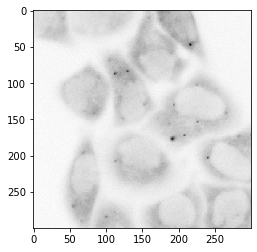

In [3]:
# load test data
ds_src = ij.io().open('sample-data/test_still.tif')
ds_src = ij.op().convert().int32(ds_src) # convert image to 32-bit
ij.py.show(ds_src, cmap='binary')

There are many ways to background subtract/supress noise in an image. In this example we take a duplicate of the input image, here `ds_mean`, apply a mean filter with a radius of `5` and then multiply it back to the original image. The trick to this operation improving the signal-to-noise ratio lies in the application of the mean filter. In the background area outside of the cell high value pixels are generally intermixed with low value ones. In contrast the high value pixels in the object of interest are surrounded by high value ones. When the mean filter is applied, the high value pixels in the background are averaged with low values and high values pixels in the object are averaged with other high value pixels. When this mean filtered image is multiplied with the original image, the background noise is multiplied by a “smaller” number than the objects/signal of interest. Note that these are destructive changes and the resulting background supressed image is not sutible for measurements. Instead, these processes are done to generate masks and labels which can then be applied over the original data to obtain measurements that are unmodified.

Here we are using ImageJ ops to apply the mean filter. You can also apply the filter using `ij.py.run_plugin(imp, "Mean...", "radius=2")`. Note that using the original ImageJ plugins/functions like "Mean..." require the `ImagePlus` image data type. In this case we can convert the `ds_mean` into an `ImagePlus` like so:

```python
imp = ij.py.to_imageplus(ds_mean)
```

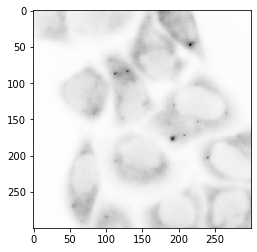

In [4]:
# supress background noise
mean_radius = HyperSphereShape(5)
ds_mean = ij.dataset().create(ds_src.copy())
ij.op().filter().mean(ds_mean, ds_src.copy(), mean_radius)
ds_mul = ds_src * ds_mean
ij.py.show(ds_mul, cmap='binary')

Here we employ a gaussian blur subtraction to futher enhance the puncta for segmentation. For more information on gaussian blurs and how they can be used in image processing please checkout [Peter Bankhead's amazing online book](https://petebankhead.gitbooks.io/imagej-intro/content/chapters/filters/filters.html).

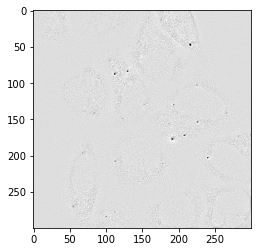

In [5]:
# use gaussian subtraction to enhance puncta
img_blur = ij.op().filter().gauss(ds_mul.copy(), 1.2)
img_enhanced = ds_mul - img_blur
ij.py.show(img_enhanced, cmap='binary')

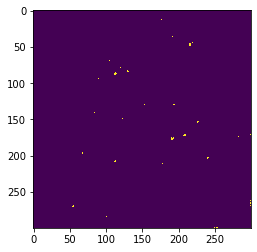

In [6]:
# apply threshold
img_thres = ij.op().threshold().renyiEntropy(img_enhanced)
ij.py.show(img_thres)

Finally we convert the threshold image into an `ImagePlus` with `ij.py.to_imageplus()` and run the "Analyze Particles" plugin. The `ResultsTable` that is returned by the "Analyze Particles" plugin first needs to be converted to a SciJava table (_i.e._ `org.scijava.table.Table`) before it can be converted to a pandas DataFrame.

In [7]:
# convert ImgPlus to ImagePlus
imp_thres = ij.py.to_imageplus(img_thres)

# get ResultsTable and set ParticleAnalyzer
rt = ij.ResultsTable.getResultsTable()
ParticleAnalyzer.setResultsTable(rt)

# set measurements
ij.IJ.run("Set Measurements...", "area center shape")

# run the analyze particle plugin
ij.py.run_plugin(plugin="Analyze Particles...", args="clear", imp=imp_thres)

# convert results table -> scijava table -> pandas dataframe
sci_table = ij.convert().convert(rt, Table)
df = ij.py.from_java(sci_table)

# print dataframe
print(df)

Operating in headless mode - the original ImageJ will have limited functionality.
Operating in headless mode - the ResultsTable class will not be fully functional.
Operating in headless mode - the IJ class will not be fully functional.


    Area          XM          YM     Circ.        AR     Round  Solidity
0    2.0  159.500000   10.000000  1.000000  2.000000  0.500000  1.000000
1    2.0  176.500000   13.000000  1.000000  2.000000  0.500000  1.000000
2    1.0  191.500000   36.500000  1.000000  1.000000  1.000000  1.000000
3    1.0  217.500000   43.500000  1.000000  1.000000  1.000000  1.000000
4    1.0  219.500000   44.500000  1.000000  1.000000  1.000000  1.000000
5    9.0  216.500000   47.500000  1.000000  1.000000  1.000000  1.000000
6    1.0  105.500000   69.500000  1.000000  1.000000  1.000000  1.000000
7    1.0  120.500000   79.500000  1.000000  1.000000  1.000000  1.000000
8    7.0  130.214286   84.500000  1.000000  1.068847  0.935588  0.875000
9    8.0  113.375000   87.625000  0.620562  2.250157  0.444413  0.727273
10   1.0   90.500000   94.500000  1.000000  1.000000  1.000000  1.000000
11   1.0  140.500000   96.500000  1.000000  1.000000  1.000000  1.000000
12   2.0  153.500000  130.000000  1.000000  2.00000